Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#the paths needs to be updated based on the environment the notebook is being run on
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Our dataset has 2239 images for training and 118 for validation

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset="training",
   follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
 color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=False, seed=123, validation_split=0.2, subset="validation",
    follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

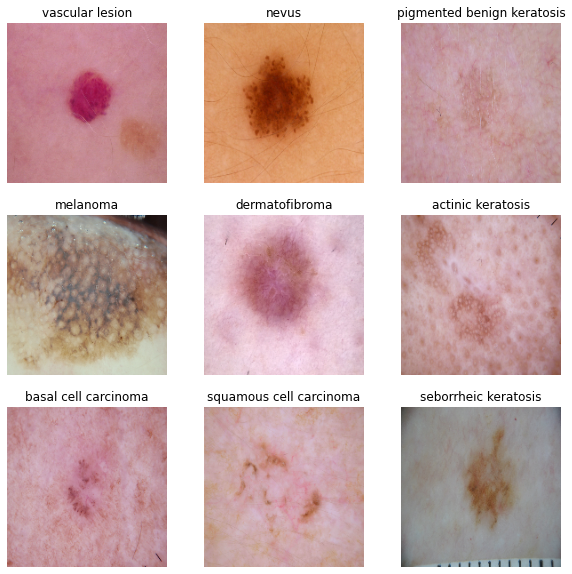

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
dp = {}

#storing image of each class into a dictionary and then visualizing using matplotlib's imshow
for images, labels in train_ds.take(3):
    for i in range(32):
        #ax = plt.subplot(6, 6, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        #plt.axis("off")
        key = class_names[labels[i]]
        val = images[i].numpy().astype("uint8")
        dp[key] = val

plt.figure(figsize=(10,10))
j=0
for key,val in dp.items():
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(val)
        plt.title(key)
        plt.axis("off")
        j = j+1 


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

There are two approaches to Rescaling of the images. One way is to manually rescale before creating the model. We will be following the other approach of doing it alongside the model creation. 

We use 3 Convolution layers of kernel size 3 and 16, 32 and 64 filters for each layer respectively. We will use a Maxpool layer after each of the convolutional layer. Apart from these a flatten layer and dense layer are used at the end. The output layer is a dense layer with its activation function set to softmax since we need to classify the images. 

In [12]:
#Lets create the model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
IMG_SIZE = 180


# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
num_classes = 9

model = Sequential([
  #layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.experimental.preprocessing.Rescaling((1./255), input_shape = (IMG_SIZE,IMG_SIZE,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.Dropout(0.5),
  layers.Dense(num_classes,activation="softmax")
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

Reference for choosing optimiser : https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

The adaptive optimizers don't focus much on manual tuning of learning rate, among which 'Adam' is the best and it has lower memory requirements. We will select it as our optimizer

Reference for choosing loss function : https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

Considering that we haven't one hot encoded the target elements of the datasets, sparse_categorical_crossentropy can be used since it doesn't have such pre-requisites.

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              #loss="categorical_crossentropy",
              loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 144s 1s/step - loss: 2.0891 - accuracy: 0.2288 - val_loss: 2.4897 - val_accuracy: 0.1051
Epoch 2/20
56/56 [==============================] - 73s 1s/step - loss: 1.8510 - accuracy: 0.3304 - val_loss: 2.3960 - val_accuracy: 0.1119
Epoch 3/20
56/56 [==============================] - 86s 2s/step - loss: 1.5865 - accuracy: 0.4487 - val_loss: 1.8283 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 78s 1s/step - loss: 1.3994 - accuracy: 0.5145 - val_loss: 1.4805 - val_accuracy: 0.3579
Epoch 5/20
56/56 [==============================] - 72s 1s/step - loss: 1.3670 - accuracy: 0.5156 - val_loss: 1.4859 - val_accuracy: 0.3087
Epoch 6/20
56/56 [==============================] - 76s 1s/step - loss: 1.3225 - accuracy: 0.5368 - val_loss: 1.9722 - val_accuracy: 0.2752
Epoch 7/20
56/56 [==============================] - 75s 1s/step - loss: 1.2467 - accuracy: 0.5513 - val_loss: 1.2164 - val_accuracy: 0.4564
Epoch 8/20
56/56 [=

### Visualizing training results

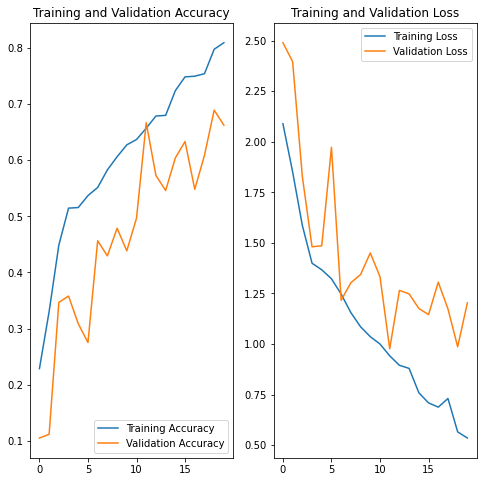

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here


We can observe that the model is <b> overfitting </b> . There is a huge gap between the test and training accuracy. 

Below are some techniques that can be used to handle overfitting.

- Dropout regularization
- Data augmentation - each image is rotating 
- oversampling the minority classes or undersampling the majority classes

Data augmentation is a practice that allows us to improve the diversity of the data. The images are flipped, rotated, zoomed, rescaled before training the network. 

Droput regularization is aimed at improving the generalizing the network. In this technique, random neurons are ignored during the training. 

Lets try data augmentation and dropout regularization using the keras preprocessing layers.  



In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  #layers.experimental.preprocessing.RandomZoom(0.1)
])

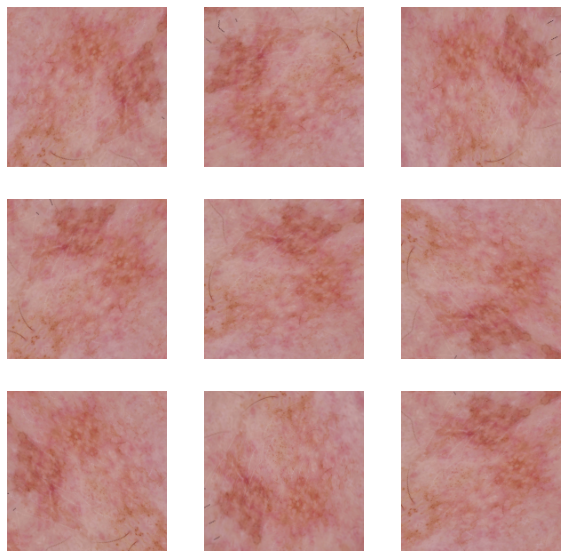

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

#applying augmentation to the image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
  

We can see how each image is rotated and flipped. We can include this as one of the layers while building the model and check if it improves the model.

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
 # layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes,activation="softmax")
])



### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              #loss="categorical_crossentropy",
              loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 86s 1s/step - loss: 2.0095 - accuracy: 0.2684 - val_loss: 2.3187 - val_accuracy: 0.0515
Epoch 2/20
56/56 [==============================] - 86s 2s/step - loss: 1.7132 - accuracy: 0.3756 - val_loss: 2.2974 - val_accuracy: 0.0559
Epoch 3/20
56/56 [==============================] - 85s 2s/step - loss: 1.5925 - accuracy: 0.4353 - val_loss: 1.9795 - val_accuracy: 0.1879
Epoch 4/20
56/56 [==============================] - 85s 2s/step - loss: 1.5034 - accuracy: 0.4688 - val_loss: 1.5033 - val_accuracy: 0.3356
Epoch 5/20
56/56 [==============================] - 86s 2s/step - loss: 1.4996 - accuracy: 0.4827 - val_loss: 1.5978 - val_accuracy: 0.3445
Epoch 6/20
56/56 [==============================] - 84s 2s/step - loss: 1.4170 - accuracy: 0.4944 - val_loss: 1.3993 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 88s 2s/step - loss: 1.4230 - accuracy: 0.5067 - val_loss: 1.5630 - val_accuracy: 0.3445
Epoch 8/20
56/56 [==

### Visualizing the results

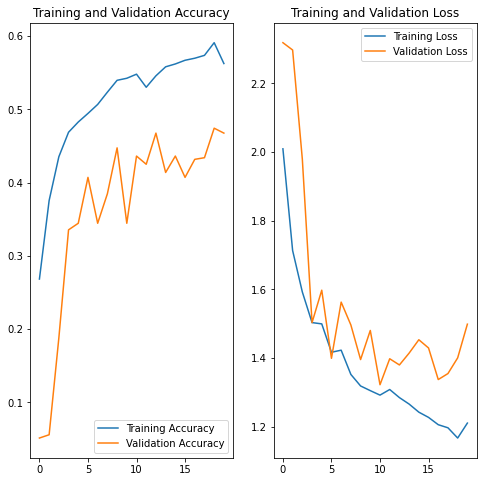

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We can see the model is still overfitting. The accuracy between the training and validation set has reduced considerably now. However, the accuracy has dropped for both.

We can further improve this balance by checking the distribution of samples for each classes, checking for any imbalance and taking actions accordingly.


Resources for imbalanced datasets - https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
#Your code goes here
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [24]:
dataframe_dict_original = dict(zip(path_list,lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


actinic keratosis
Class=0,n=114 (5.092%)
basal cell carcinoma
Class=1,n=376 (16.793%)
dermatofibroma
Class=2,n=95 (4.243%)
melanoma
Class=3,n=438 (19.562%)
nevus
Class=4,n=357 (15.945%)
pigmented benign keratosis
Class=5,n=462 (20.634%)
seborrheic keratosis
Class=6,n=77 (3.439%)
squamous cell carcinoma
Class=7,n=181 (8.084%)
vascular lesion
Class=8,n=139 (6.208%)


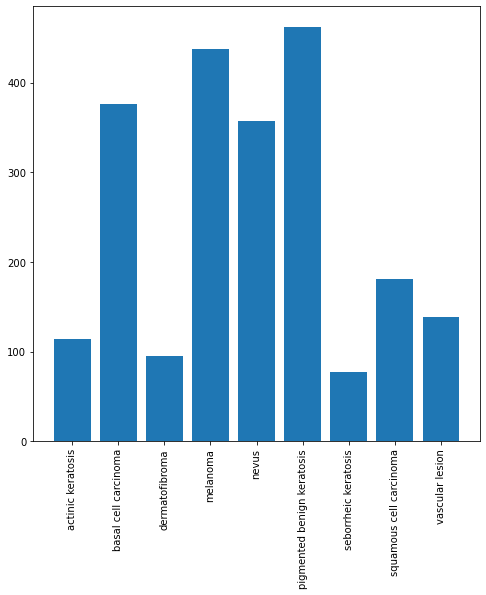

In [25]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
#split into input and output elements
X,y = original_df['Path'],original_df['Label']
#label encode the target variable
y = LabelEncoder().fit_transform(y)
#summarize distribution
counter = Counter(y)
for k,v in counter.items():
  per = v/len(y) * 100
  print(class_names[k])  
  print('Class=%d,n=%d (%.3f%%)' % (k,v,per))
#plot the distribution
plt.figure(figsize=(8,8))
plt.bar(counter.keys(),counter.values())
plt.xticks([0,1,2,3,4,5,6,7,8],class_names,rotation=90)
plt.show()

#### **Todo:** Write your findings here: 

#### - Which class has the least number of samples?
We observe that the class "seborrheic keratosis" has the least number of samples


#### - Which classes dominate the data in terms proportionate number of samples?
In terms of propotionate number of samples, the class "pigmented benign keratosis" dominates the data



We can clearly observe data imbalance in this dataset. We can rectify this.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset= "Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27BDF4CE100>: 100%|█| 500/500 [00:16<00:00, 30.24 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x27BDF1E9790>: 100%|█| 500/500 [00:16<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27BDF4F0580>: 100%|█| 500/500 [00:16<00:00, 29.66 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x27BDF496430>: 100%|█| 500/500 [01:25<0
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x27BDE200C70>: 100%|█| 500/500 [01:24<00:00,  5.94 Sample
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27BDF20C340>: 100%|█| 500/500 [00:16<00:00, 30.48 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x27BDE200EB0>: 100%|█| 500/500 [00:37<00
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27BDEF564F0>: 100%|█| 500/500 [00:16<00:00, 29.50 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x27BDEF576A0>: 100%|█| 500/500 [00:17<00:00, 28.39 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
#this path should contain the directory to the training dataset where the augmentor stores the newly augmented images
data_dir_train = pathlib.Path("C:/Users/user/Documents/Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\user\\Documents\\Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8c34a71e-cb92-418c-9ed6-328eae4008c7.jpg',
 'C:\\Users\\user\\Documents\\Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9c180291-d400-4955-b460-7fedd236cc38.jpg',
 'C:\\Users\\user\\Documents\\Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a431658c-6a3a-4eed-a598-352bd47dade5.jpg',
 'C:\\Users\\user\\Documents\\Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a7fde8c5-76a8-4d67-804a-cea2adb5b3ef.jpg',
 'C:\\Users\\user\\Documents\\Assignment\\Skin cancer ISIC The International Skin Imaging Collab

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here
model = Sequential([
 # layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes,activation="softmax")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer='adam',
              #loss="categorical_crossentropy",
              loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 319s 2s/step - loss: 1.8861 - accuracy: 0.2880 - val_loss: 1.6114 - val_accuracy: 0.4001
Epoch 2/30
169/169 [==============================] - 288s 2s/step - loss: 1.5985 - accuracy: 0.3869 - val_loss: 1.5420 - val_accuracy: 0.4053
Epoch 3/30
169/169 [==============================] - 293s 2s/step - loss: 1.4774 - accuracy: 0.4318 - val_loss: 1.3847 - val_accuracy: 0.4655
Epoch 4/30
169/169 [==============================] - 285s 2s/step - loss: 1.4216 - accuracy: 0.4562 - val_loss: 1.4340 - val_accuracy: 0.4566
Epoch 5/30
169/169 [==============================] - 288s 2s/step - loss: 1.3588 - accuracy: 0.4714 - val_loss: 1.3071 - val_accuracy: 0.4774
Epoch 6/30
169/169 [==============================] - 287s 2s/step - loss: 1.3391 - accuracy: 0.4831 - val_loss: 1.2455 - val_accuracy: 0.5071
Epoch 7/30
169/169 [==============================] - 287s 2s/step - loss: 1.2873 - accuracy: 0.5020 - val_loss: 1.2315 - val_accuracy: 0.5212

#### **Todo:**  Visualize the model results

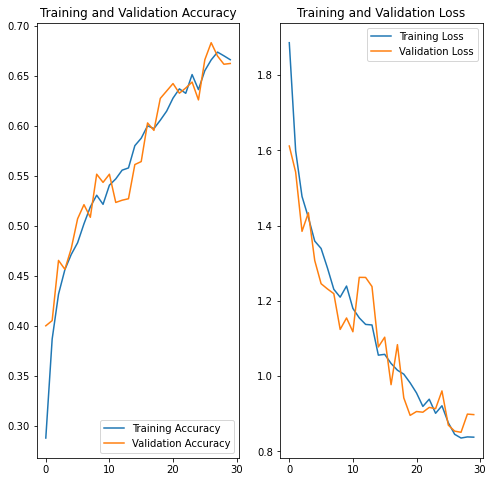

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Although the train accuracy is not very high, the gap between the train and validation accuracy is considerably less now. This means the model has generalized well. The rebalancing of the classes helped get rid of the overfitting

Summary :
- The first model built was built after resizing and rescaling the images. This model was overfitting with a very high gap between train and test accuracy.

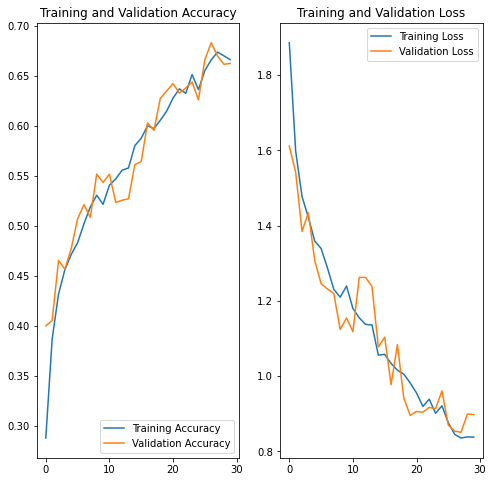

- The second model was built including data augmentation and dropout layer. Even though this model was also overfitting, the gap between train and test accuracy had reduced

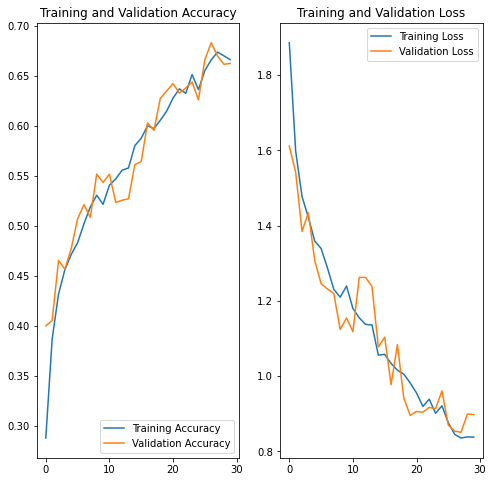


-  The third model was built after augmentor was used to handle class imbalance. The accuracy of the train and test set are quite similar to each other. The model has generalized well after data imbalance was rectified

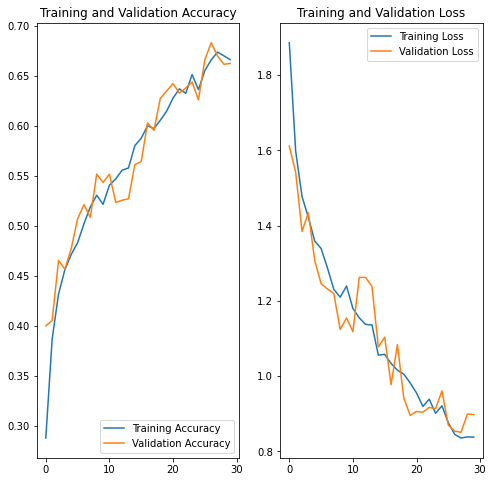